<a href="https://colab.research.google.com/github/michaeledge27/CSCI290/blob/main/notebooks/cleanedKMeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Means Method

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.ticker import FixedLocator, FixedFormatter

In [ ]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [ ]:
# return random sample of k initial centroids
def get_random_centroids(df, k):
    return df.sample(k)[df.columns[:-1]]

In [ ]:
# compare old centroids to new centroids to see if the algorithm has converged yet
# return true if new_centroids is equal to old_centroids, false otherwise
def check_new_centroids(old_centroids, new_centroids):
    if old_centroids.empty:
        return False  # Return False at start of loop
    common_columns = list(set(old_centroids.columns) & set(new_centroids.columns) & set(df.columns[:-1]))
    return np.allclose(old_centroids[common_columns].values, new_centroids[common_columns].values, atol=0.001)
    # return np.allclose(old_centroids[df.columns[:-1]].values, new_centroids[df.columns[:-1]].values, atol=0.001)

In [ ]:
def update_centroids(df):
    return df.groupby("current_cluster").mean()[df.columns[:-1]]

In [ ]:
# plot data and centroids for each iteration
def plot_clusters(df, centroids, iteration, x, y):
    plt.figure(figsize=(5, 3))

    # Plot each cluster
    sns.scatterplot(x, y, data = df, hue = "current_cluster");

    # Plot the centroids
    plt.scatter(
        centroids[x], centroids[y],
        color="red", marker="X", s=200, label="Centroids"
    )

    plt.title(f'Iteration {iteration}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()
    plt.pause(1)
    clear_output(wait=True)

In [ ]:
def get_cluster(df, centroids, x=None, y=None, plot=True):
    # initialize old centroids as an empty dataframe
    old_centroids = pd.DataFrame()
    # keep track of what iteration we are on for plotting
    iteration = 0
    # run iteratively while the new centroids are different from the old ones
    while not check_new_centroids(old_centroids, centroids):
        # update the old centroids
        old_centroids = centroids.copy()
        # iterate over each point in the data frame
        for i in df.index:
            # store distances from current point to each centroid
            distances = []
            # iterate over each centroid
            for _, centroid in centroids.iterrows():
                # calculate euclidean distance from current point to current centroid
                distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], centroid))
            # assign the point to the cluster with the closest centroid
            closest_cluster = np.argmin(distances)
            df.loc[i, 'current_cluster'] = closest_cluster

        if plot:
          # plot clusters and centroids
          plot_clusters(df, centroids, iteration, x, y)
        #update centroids
        centroids = update_centroids(df)
        iteration += 1
    return df


In [173]:
def calculate_accuracy(df, clustered_df):
    accuracy = 0
    for i in df.index:
        if df.loc[i, 'family_name'] == clustered_df.loc[i, 'current_cluster']:
            accuracy += 1
    return accuracy / len(df)


In [161]:
def get_inertia(df, centroids):
    # initialize as 0
    inertia = 0
    # loop through each point
    for i in df.index:
        # get cluster assignment
        cluster = df.loc[i, 'current_cluster']
        # calculate euclidean distance between the point and its assigned centroid
        distance = euclidean_distance(df.loc[i, df.columns[:-1]], centroids.loc[cluster])
        # add the squared distance to the total inertia
        inertia += distance**2
    return inertia

In [162]:
def plot_intertia(df):
  inertias = []
  for i in range(1, 11):
      centroids = get_random_centroids(df, i)
      clustered_df = get_cluster(df, centroids, plot=False)
      inertia = get_inertia(clustered_df, update_centroids(clustered_df))
      inertias.append(inertia)


  plt.plot(range(1, 11), inertias, marker='o')
  plt.title('Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.show()

In [163]:
def initialize_centroids(df, k):
    # initialize list to hold k centroids
    centroids = []
    # randomly select first centroid
    first_centroid = df.sample(1).iloc[0]
    # add it to the centroid list
    centroids.append(first_centroid)
    # get remaining k-1 centroids
    for i in range(1, k):     # k is exclusive
        # initialize list to hold distances from new centroids to the first centroid
        distances = []
        # loop through each point in the data frame
        for i in df.index:
            point = df.loc[i, df.columns[:-1]]
            # Calculate the distance from the current point to each centroid
            min_distance = min(euclidean_distance(point, centroid) for centroid in centroids)
            distances.append(min_distance**2)  # Append squared distance
        # compute probabilities
        probabilities = distances / np.sum(distances)
        # select new centroid
        new_centroid = df.sample(1, weights=probabilities).iloc[0]
        # add new centroid to list
        centroids.append(new_centroid)

    return pd.DataFrame(centroids, columns=df.columns[:-1])

In [ ]:
# calculate mean inter cluster distance (a_i)
def mean_icd(df, point_index):
    distances = []
    # get the current cluster of the point
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all points in the current cluster
    cluster_points = df[df['current_cluster'] == current_cluster]
    # loop through all points in current cluster
    for i in cluster_points.index:
        # exclude the point itself
        if i != point_index:
            # calculate and append mean distance between the current point and all other points
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))

    return np.mean(distances) if distances else 0

In [ ]:
# calculate mean nearest cluster distance (b_i)
def mean_ncd(df, point_index):
    total_distances = []
    # get the current cluster
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all other clusters
    other_clusters = df[df['current_cluster'] != current_cluster]
    # loop through each unique cluster in other_clusters
    for cluster in other_clusters['current_cluster'].unique():
        # get all points belonging to the cluster being considered
        cluster_points = df[df['current_cluster'] == cluster]
        # compute distance to all points in the current cluster
        distances = []
        for i in cluster_points.index:
            # calculate distance between this point and each point in the current cluster
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))
        # calculate mean distance to the current cluster
        total_distances.append(np.mean(distances))
    # return minimum mean distance among all clusters
    return min(total_distances)


In [ ]:
def get_silhouette_coefficients(df):
    # get all points in the current cluster
    # df = df[df['current_cluster'] == cluster]
    # store coefficients for a cluster
    silhouette_coefficients = []
    # loop through each point in the cluster
    for i in df.index:
        # calculate mean inter cluster distance
        a = mean_icd(df, i)
        # calculate mean nearest cluster distance
        b = mean_ncd(df, i)
        # compute silhouette coefficient for each point
        silhouette_coefficients.append((b - a) / max(a, b))
    new_df = pd.DataFrame( { 'silhouette coefficient': silhouette_coefficients,
                                 'current_cluster': df['current_cluster'] } )
    # return silhouette coefficients for all points in the cluster
    return new_df

In [ ]:
def silhouette_plots(df):
    for k in range(2, 10):
        plt.subplot(4, 2, k-1)
        centroids = initialize_centroids(df, k)
        clustered_df = get_cluster(df, centroids, plot=False)
        new_df = get_silhouette_coefficients(clustered_df)
        silhouette_score = np.mean(new_df['silhouette coefficient'])
        padding = len(new_df) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = new_df[new_df['current_cluster'] == i]['silhouette coefficient']
            coeffs = list(coeffs)
            coeffs.sort()
            color = plt.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        plt.ylabel("Cluster")

        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.axvline(x=silhouette_score, color="red", linestyle="--")
        plt.title(f"$k={k}$")

    plt.show()

# testing on iris

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
iris = load_iris()

In [ ]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


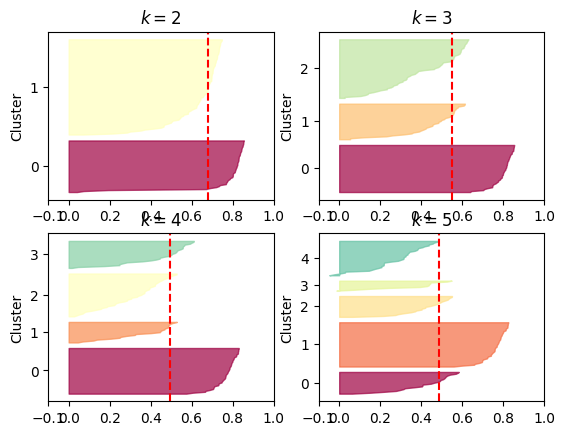

In [ ]:
silhouette_plots(df)

# testing on penguins

In [ ]:
df = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/penguins.csv")
df = df.dropna()
df.drop(columns=['island', 'sex', 'year', 'species'], inplace=True)
df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
339,55.8,19.8,207.0,4000.0
340,43.5,18.1,202.0,3400.0
341,49.6,18.2,193.0,3775.0
342,50.8,19.0,210.0,4100.0


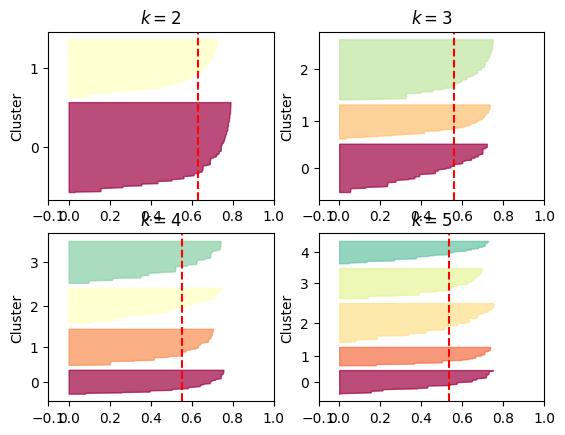

In [ ]:
silhouette_plots(df)

# mystery dataset

In [ ]:
df = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/mystery.csv")
df

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,-0.145668,-0.059364,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,-0.164675,-0.105600,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,-0.150025,-0.078615,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,-0.153120,-0.075320,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895


In [ ]:
df.dropna()

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,-0.145668,-0.059364,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,-0.164675,-0.105600,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,-0.150025,-0.078615,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,-0.153120,-0.075320,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895


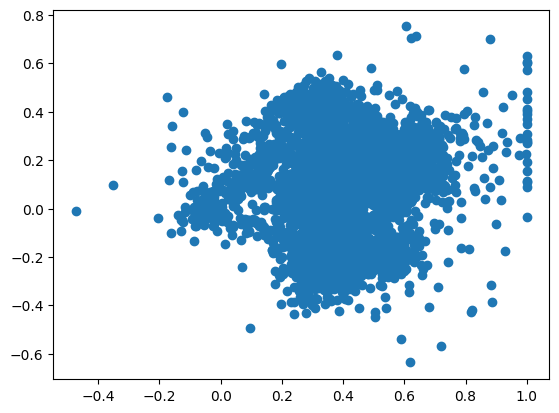

In [ ]:
plt.scatter(df.columns[3], df.columns[4], data=df)

KeyboardInterrupt: 

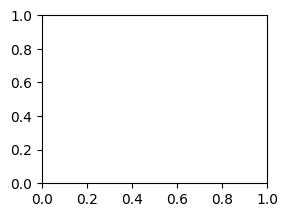

In [ ]:
silhouette_plots(df)

In [113]:
df = df.sample(400).sample(8, axis=1)
df

,feature_ 1,feature_18,feature_ 5,feature_ 3,feature_11,feature_ 2,feature_14,feature_12
1047,1.0,0.040201,-0.012394,-0.159690,-0.059373,0.271290,0.323011,0.026225
394,1.0,0.145950,-0.188415,0.686698,0.220113,0.619824,0.270554,-0.159329
5413,1.0,-0.054854,0.008922,0.513180,-0.082140,0.596724,-0.174219,0.266863
782,1.0,-0.008599,0.321853,-0.039274,-0.118414,-0.096100,0.179893,-0.155302
2761,1.0,0.002205,0.137993,0.373323,-0.335717,0.482671,-0.087018,0.011932
...,...,...,...,...,...,...,...,...
7086,1.0,0.002899,-0.025580,0.689355,-0.014365,0.350180,0.017252,0.141778
6099,1.0,0.049492,0.155603,0.320745,0.042713,0.171883,-0.034006,0.056494
4317,1.0,-0.088984,0.159722,0.285366,-0.221984,0.224214,-0.264488,0.232878
7044,1.0,-0.007568,0.077981,0.245392,0.053385,0.333338,-0.029010,0.064500


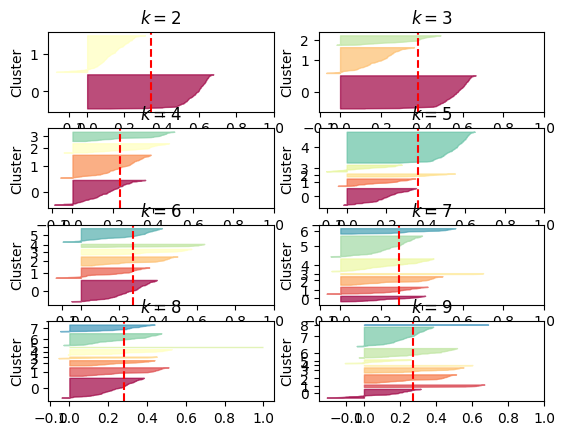

In [ ]:
silhouette_plots(df)

In [123]:
df

,feature_ 1,feature_18,feature_ 5,feature_ 3,feature_11,feature_ 2,feature_14,feature_12,current_cluster
7044,1.0,-0.007568,0.077981,0.245392,0.053385,0.333338,-0.029010,0.064500,1.0
1844,1.0,0.064122,0.225146,0.072838,-0.259847,0.171415,-0.053530,0.104469,1.0
1747,1.0,0.056850,0.264470,0.112694,-0.333478,0.134086,-0.082745,0.088895,1.0
219,1.0,-0.274816,0.424365,-0.134727,0.417670,0.156945,0.004244,-0.192123,3.0
5242,1.0,0.014998,0.004468,0.705865,0.006221,0.648799,-0.268814,0.354148,2.0
...,...,...,...,...,...,...,...,...,...
4927,1.0,-0.013856,0.225817,0.177284,0.268324,0.371865,-0.091611,-0.014811,3.0
6781,1.0,0.010817,-0.286707,0.745253,-0.126155,0.277954,0.080452,-0.050211,2.0
6099,1.0,0.049492,0.155603,0.320745,0.042713,0.171883,-0.034006,0.056494,1.0
1260,1.0,0.014105,0.163065,0.319964,-0.268099,0.439177,-0.120790,0.130764,0.0


In [118]:
clustered_df = get_cluster(df, initialize_centroids(df, 4), plot=False)


In [119]:
new_df = pd.read_csv("https://github.com/michaeledge27/CSCI290/raw/refs/heads/main/data/mystery_family.csv")
new_df

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,family
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,-0.059364,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,-0.105600,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,-0.078615,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,-0.075320,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae


In [122]:
new_df.dropna()
new_df.sample(400, random_state=1)

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,family
4760,1.0,0.104201,0.265481,0.551810,0.078270,-0.118555,0.095479,0.082407,-0.064890,0.085840,...,0.100933,0.029098,-0.051063,0.043093,0.071320,-0.043916,-0.047089,0.022879,0.034093,Hylidae
1999,1.0,0.300532,0.259906,0.607010,0.153048,-0.064740,-0.141629,0.078802,0.252198,-0.059811,...,-0.101128,-0.247891,0.148660,0.218576,-0.028827,-0.122269,-0.097897,0.033834,0.124764,Leptodactylidae
343,1.0,0.625136,0.687237,0.583013,-0.137969,-0.079318,0.428873,0.093345,-0.290215,0.115262,...,0.154197,-0.013495,-0.173507,0.052333,0.127297,-0.029843,0.031279,0.061858,0.020855,Leptodactylidae
2623,1.0,0.447066,0.398681,0.512818,0.064754,0.001957,-0.033550,0.078006,0.232600,-0.001685,...,-0.075473,-0.228063,0.147863,0.196299,-0.043328,-0.045204,-0.019360,0.087126,0.160549,Leptodactylidae
573,1.0,0.472749,0.665158,0.555585,-0.227115,-0.038111,0.411873,0.001406,-0.360398,0.204005,...,0.256171,0.088659,-0.132581,0.043303,0.101327,-0.064806,-0.004610,0.088149,0.035782,Leptodactylidae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,1.0,0.448245,0.265682,0.575346,0.194668,0.063253,-0.062132,0.075856,0.241269,0.043420,...,-0.079210,-0.217767,0.019121,0.161288,0.016443,-0.072386,-0.153759,0.010702,0.164989,Leptodactylidae
1297,1.0,0.360854,0.374545,0.514212,0.064681,0.042034,-0.053355,0.132582,0.308754,-0.099779,...,-0.247034,-0.140847,0.270222,0.146754,-0.086962,-0.078845,-0.009231,0.173616,0.150705,Leptodactylidae
6241,1.0,0.503265,0.409878,0.331318,0.156514,0.282965,0.062742,-0.134226,0.127762,0.138899,...,-0.154859,-0.067679,0.186679,0.061995,-0.040462,-0.004134,-0.031149,0.032887,0.154974,Hylidae
169,1.0,0.828310,0.243861,0.135409,0.166489,0.386477,0.435395,0.219620,0.026417,-0.152293,...,-0.034042,0.042109,-0.171347,-0.301549,-0.475986,-0.471597,-0.208141,-0.007926,0.030605,Leptodactylidae


In [147]:
df = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/mystery.csv")
labeled_df = pd.read_csv("https://github.com/michaeledge27/CSCI290/raw/refs/heads/main/data/mystery_family.csv")

In [148]:
clustered_df = get_cluster(df, initialize_centroids(df, 4), plot=False)

In [157]:
clustered_df2 = get_cluster(df, get_random_centroids(df, 4), plot=False)

In [150]:
clustered_df

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,current_cluster
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,3.0
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,3.0
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,3.0
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,3.0
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,-0.059364,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,3.0
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,-0.105600,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,3.0
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,-0.078615,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,3.0
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,-0.075320,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,3.0


In [151]:
clustered_df['current_cluster'].unique()

array([3., 2., 1., 0.])

In [152]:
labeled_df['family'].unique()

array(['Leptodactylidae', 'Dendrobatidae', 'Hylidae', 'Bufonidae'],
      dtype=object)

In [153]:
target_names = {
    "Leptodactylidae": 0,
    "Dendrobatidae": 1,
    "Adenomera": 2,
    "Hylidae": 3

}

labeled_df["family_name"] = labeled_df["family"].map(target_names)
labeled_df

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,family,family_name
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,0.0
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,0.0
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,0.0
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,0.0
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,3.0
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,3.0
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,3.0
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,3.0


In [154]:
labeled_df

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,family,family_name
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,0.0
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,0.0
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,0.0
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,0.0
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,3.0
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,3.0
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,3.0
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,3.0


In [155]:
clustered_df

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,current_cluster
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,3.0
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,3.0
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,3.0
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,3.0
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,-0.059364,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,3.0
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,-0.105600,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,3.0
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,-0.078615,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,3.0
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,-0.075320,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,3.0


In [171]:
calculate_accuracy(labeled_df, clustered_df)

0.6622654621264767